## 1. Get Raw Astropy Data

In [5]:
import gc
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.table import Table
from astropy.io import fits

In [79]:
# choose desi data release, target galaxy type (could be wrongly determined, need rule out non galaxy targets later)
target_name = "ELG"
data = Table.read(f'../data/iron-KiDS-{target_name}.fits', hdu="ZCATALOG")
# hdulist = fits.open(f'../data/iron-KiDS-{target_name}.fits')
# hdulist.info()

In [83]:
print(np.unique(np.array(data["SPECTYPE"], dtype="str")))
data[:3]

['GALAXY' 'QSO' 'STAR']


TARGETID,SURVEY,PROGRAM,FIRSTNIGHT,LASTNIGHT,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,PRIORITY,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,PLATE_RA,PLATE_DEC,TILEID,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_X,MEAN_FIBER_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MIN_MJD,MAX_MJD,MEAN_MJD,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,MAIN_NSPEC,MAIN_PRIMARY,SV_NSPEC,SV_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY,DESINAME
,,,,,,,,,,,,,,,,,,,,,deg,deg,mas / yr,mas / yr,yr,Angstrom,,,,mm,mm,,,,,,,,,mag,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy^-2,nanomaggy^-2,nanomaggy^-2,nanomaggy^-2,nanomaggy^-2,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,nanomaggy,,,arcsec,,,,,mag,mag,mag,mas,,,,,,,,,,,,,,,,,,,,,deg,deg,,,s,,,mm,mm,mm,mm,,mm,mm,deg,arcsec,deg,arcsec,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,bytes7,bytes6,int32,int32,int32,float64,float64,int64,float64,float64[10],int64,bytes6,bytes20,int64,float64,int16,int32,int64,int32,int32,float64,float64,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int32,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int32,int16,float32,int16,int16,float32,float32,float32,float32,float32,float32,float32,float64,float32,float64,float32,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,bool,int16,bool,int16,bool,bytes22
39636608957287040,main,bright,20210609,20210609,20210609,0.735236376737678,0.00021059863767976204,0,7668.967475390062,0.8096358807164004 .. 0.0,7848,QSO,LOZ,4,105.24627841822803,4,397,4397,2196,0,237.12988963930846,0.9846187252709787,-0.78889036,0.8530999,2015.5,5400.0,1152921504607502434,1,TGT,291.31552,248.0183,2000,0.5956282285858943,517,9012,2371p010,337076,2688,REX,0.097547084,5.2370977,6.60978,9.061281,40.8621,38.56908,478.44708,237.10822,43.635223,2.4697897,0.63371,3.4959078,4.4122114,6.0486565,3.4959078,4.4122114,6.0486565,0,1.0,0.27559835,0.0,0.0,4422692618294513920,G2,20.836832,20.607641,19.927036,-2.6638594,S,2000,2,0,1152921504607502434,262148,0,0,0,0,0,0,0,0,0,0,0,0,0,0,237.12988963930846,0.9846187252709787,20000,1,1038.3943,1,1,0.008,0.008,0.004,0.004,0.7807264,291.3

In [84]:
# galaxy selection
is_galaxy = data["SPECTYPE"] == "GALAXY"
galaxies = data[is_galaxy]
z_criterion = 15
is_confident_galaxy = galaxies["DELTACHI2"] > z_criterion

print(f"{len(galaxies)}({len(is_confident_galaxy)}) galaxy targets, which are {is_galaxy.sum()/len(data):.2%} of total targets, others are QSO, STAR")
print(f"{is_confident_galaxy.sum()} ({is_confident_galaxy.sum()/len(galaxies):.2%}) galaxies have confident redshift by DESI redrock algorithm")

1643424(1643424) galaxy targets, which are 90.47% of total targets, others are QSO, STAR
1206085 (73.39%) galaxies have confident redshift by DESI redrock algorithm


range of redrock z: [-4.31e-03, 1.70e+00]
1640905 (99.8467%) galaxies with z in range [0, 1.698]


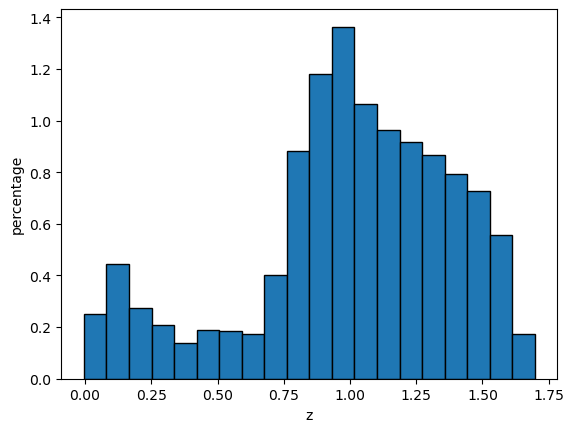

In [97]:
data = galaxies["Z"]
print(f"range of redrock z: [{data.min():.2e}, {data.max():.2e}]")
lboundary, rboundary = 0, data.max()
filters = lboundary <= data
print(f"{filters.sum()} ({filters.sum()/len(galaxies):.4%}) galaxies with z in range [{lboundary}, {rboundary:.4}]")

plt.hist(data, bins=20, edgecolor='black', density=True)
plt.xlabel("z")
plt.ylabel("percentage")
plt.show()

range of redrock z error: [2.23e-46, 2.13e-03]
1616093 (98.3369%) galaxies with z_err in range [0, 0.0002]


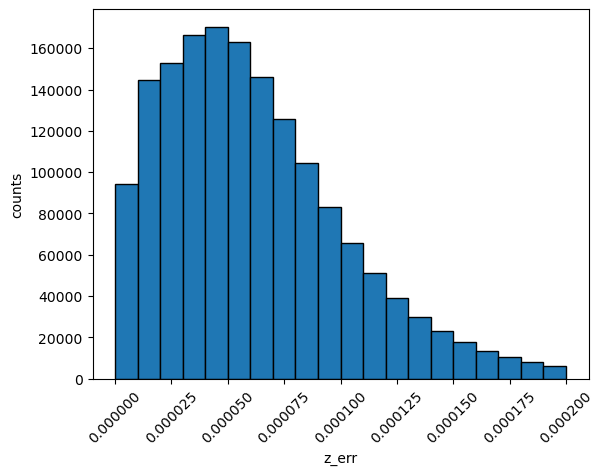

In [76]:
data = galaxies["ZERR"]
print(f"range of redrock z error: [{data.min():.2e}, {data.max():.2e}]")
rboundary = 2e-4
filters = data <= rboundary
print(f"{filters.sum()} ({filters.sum()/len(galaxies):.4%}) galaxies with z_err in range [0, {rboundary}]")

plt.hist(data[filters], bins=20, edgecolor='black', density=False)
plt.xticks(rotation=45)
plt.xlabel("z_err")
plt.ylabel("counts")
plt.show()

range of redrock CHI2: [2496, 9.00e+99]
1602010 (97.4800%) galaxies with CHI2 in range [7000, 10000]


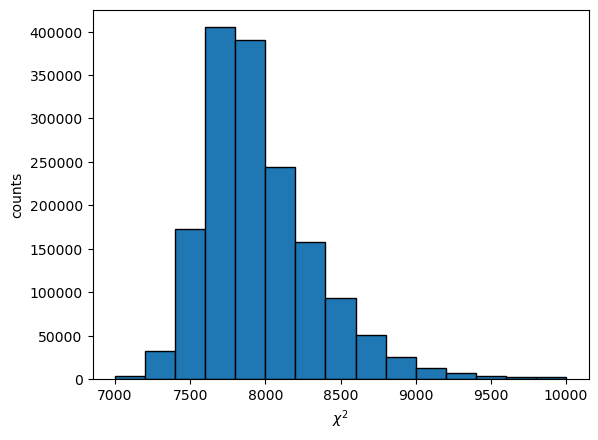

In [107]:
data = galaxies["CHI2"]
print(f"range of redrock CHI2: [{data.min():.0f}, {data.max():.2e}]")
lboundary, rboundary = 7000, 10000
filters = (lboundary <= data) & (data <= rboundary)
print(f"{filters.sum()} ({filters.sum()/len(galaxies):.4%}) galaxies with CHI2 in range [{lboundary}, {rboundary}]")

plt.hist(data[filters], bins=15, edgecolor='black', density=False)
plt.xlabel(r"$\chi^2$")
plt.ylabel("counts")
plt.show()

range of redrock DELTACHI2: [0, 7.49e+05]
1191833 (72.5213%) galaxies with DELTACHI2 in range [15, 5000]


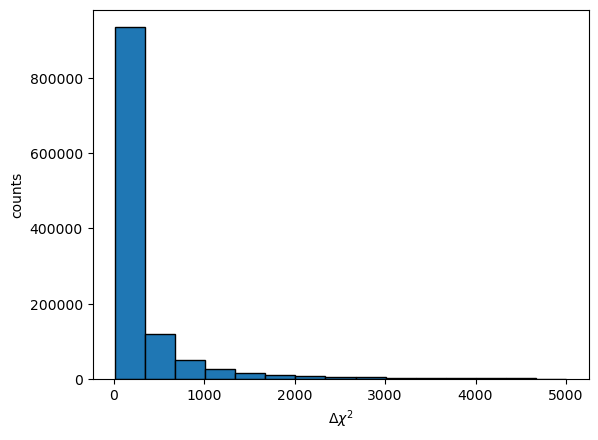

In [128]:
# DELTACHI2 = CHI2_2ndbest - CHI2_best
data = galaxies["DELTACHI2"]
print(f"range of redrock DELTACHI2: [{data.min():.0f}, {data.max():.2e}]")
lboundary, rboundary = 15, 5000
filters = (lboundary <= data) & (data <= rboundary)
print(f"{filters.sum()} ({filters.sum()/len(galaxies):.4%}) galaxies with DELTACHI2 in range [{lboundary}, {rboundary}]")

plt.hist(data[filters], bins=15, edgecolor='black', density=False)
plt.xlabel(r"$\Delta\chi^2$")
plt.ylabel("counts")
plt.show()

In [129]:
gc.collect()

9069

In [136]:
galaxies["GAIA_PHOT_G_MEAN_MAG"].data

array([ 0.      ,  0.      , 20.725872, ...,  0.      ,  0.      ,
        0.      ], dtype=float32)

## 2. Process data for training (as `CLASS DataLoader`)

In [12]:
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split
from torch import nn

In [13]:
# normalization strategy
def z_score_normalization(array):
    # -> N(0, 1)
    return (array - array.mean()) / array.std()


def min_max_normalization(array):
    # -> [0, 1]
    return (array - array.min()) / (array.max() - array.min())

In [14]:
data["FLUX_W1"].data.max()

3574.9104

In [15]:
dtype = np.float32
in_data_column = [
    # magnitude
    "EBV",
    "FLUX_G",
    "FLUX_R",
    "FLUX_Z",
    "FLUX_W1",
    "FLUX_W2",
    "FIBERFLUX_G",
    "FIBERFLUX_R",
    "FIBERFLUX_Z",
    "FIBERTOTFLUX_G",
    "FIBERTOTFLUX_R",
    "FIBERTOTFLUX_Z",
    # shape
    "SERSIC",
    "SHAPE_R",
    "SHAPE_E1",
    "SHAPE_E2",
    # exposure
    "COADD_NUMEXP",
    "COADD_EXPTIME",
]

# input data preprocess and normalization
np_in_data = np.zeros(len(galaxies))
for column in in_data_column:
    # transform flux to magnitude
    # if "FLUX_" in column:
    #     normalize = 22.5 - np.log10(data[column].data.astype(dtype))
    # else:
    #     normalize = data[column].data.astype(dtype)
    normalize = galaxies[column].data.astype(dtype)
    normalize = z_score_normalization(normalize)
    np_in_data = np.vstack((np_in_data, normalize))

np_in_data = np_in_data[1:, :].astype(dtype).T
# input data dimension
in_data_shape = np_in_data.shape[1]
print(np_in_data.shape, np_in_data.dtype)

(1643424, 18) float32


In [16]:
print(len(is_confident))
is_confident_galaxy = is_confident_galaxy[is_galaxy]
np_out_data = is_confident_galaxy.astype(dtype).squeeze()
dataset = TensorDataset(torch.as_tensor(np_in_data), torch.as_tensor(np_out_data))
print(np_out_data.shape, np_out_data.dtype)

1816597
(1643424,) float32


In [17]:
# Use random_split to create the splits
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.8, 0.1, 0.1])

In [18]:
batch_size = 256
# construct instances for class `DataLoader`, with parameters 
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# `DataLoader` instances are iterable, but not subscpriptable
print(type(train_dataloader), len(train_dataloader), len(train_dataloader)*batch_size, len(data)*0.8)

for X, y in train_dataloader:
    print(f"info of input data: {type(X)}, {X.shape}, {X.dtype}")
    print(f"info of output flag: {type(y)}, {y.shape} {y.dtype}")
    break  # only show index 0

<class 'torch.utils.data.dataloader.DataLoader'> 5136 1314816 1453277.6
info of input data: <class 'torch.Tensor'>, torch.Size([256, 18]), torch.float32
info of output flag: <class 'torch.Tensor'>, torch.Size([256]) torch.float32


In [19]:
gc.collect()

0

## 3. Define neural network and training

In [20]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=in_data_shape, out_features=64),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=64, out_features=128),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=128, out_features=64),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=64, out_features=32),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=32, out_features=1),
            nn.Sigmoid(),
        )
        self.model.to(device)

    def forward(self, inputs):
        return self.model(inputs)

model = NeuralNetwork()
print(model)

Using cuda device
NeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=18, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=32, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


In [21]:
# To train a model, we need a loss function and an optimizer.
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [22]:
# In a single training loop, the model makes predictions on the training dataset (fed to it in batches),
# and backpropagates the prediction error to adjust the model’s parameters.
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    
    model.train() # default is true, means training, false means evaluation mode
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # clear gradients for the optimizer, for next time optimization
        optimizer.zero_grad()
        
        # forward pass to predict the output with current network
        pred = model(X)
        
        # Compute the loss, output is torch.Tensor
        y = y.unsqueeze(1)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        
        # update the weights of the network
        optimizer.step()

        if batch % 400 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>7d}/{size:>7d}]")


# check the model’s performance against the test dataset to ensure it is learning.
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y = y.unsqueeze(1)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += ((pred > 0.5) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Info: \n Accuracy: {correct:0.2%}, Avg loss: {test_loss:>8f} \n")

In [23]:
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.697676  [    256/1314740]
loss: 0.541392  [ 102656/1314740]
loss: 0.504081  [ 205056/1314740]
loss: 0.466664  [ 307456/1314740]
loss: 0.505140  [ 409856/1314740]
loss: 0.474492  [ 512256/1314740]
loss: 0.426970  [ 614656/1314740]
loss: 0.525020  [ 717056/1314740]
loss: 0.503427  [ 819456/1314740]
loss: 0.450326  [ 921856/1314740]
loss: 0.499487  [1024256/1314740]
loss: 0.510227  [1126656/1314740]
loss: 0.506467  [1229056/1314740]
Test Info: 
 Accuracy: 76.42%, Avg loss: 0.480104 

Done!


In [24]:
# This model can now be used to make predictions.
classes = [
    "confident",
    "not-confident",
]

model.eval()
for x, y in test_dataloader:
    # torch.no_grad(): Context-manager that disables gradient calculation.
    with torch.no_grad():
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        print(len(pred), len(y), len(is_confident_galaxy))
        print(pred[:10], y[:10])
        print((pred > 0.5).type(torch.float).sum().item())
        print(y.sum().item())
        # predicted, actual = classes[pred[0].argmax()], classes[y[0]]
        # print(f'Predicted: "{predicted}", Actual: "{actual}"')
        # print(pred[0], pred[0].argmax())
    break

256 256 1643424
tensor([[0.8294],
        [0.5629],
        [0.8548],
        [0.9508],
        [0.8577],
        [0.9834],
        [0.9549],
        [0.4743],
        [0.4582],
        [0.8883]], device='cuda:0') tensor([1., 1., 1., 1., 1., 1., 1., 0., 0., 1.], device='cuda:0')
161.0
162.0


In [25]:
gc.collect()

0